

# Student status prediction using multiple output models and Keras Functional API

In this example I will use the student performance dataset in order to buil a model that can predict the age of the student and wheather the student in a romantic relationship or not. 
The dataset used in this example is called **[Student Performance Dataset](https://archive.ics.uci.edu/ml/datasets/Student+Performance)** from the **UCI machine learning repository**.

I will model the age of the student estimations as a regression problem and the romantic status detection as a binary classification problem.


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

## Loading the Dataset to a data frame

In [2]:
#URL of the student dataset
#URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'

# after downloading the csv file and placing it in the directory we can use the data
#student_df = pd.read_csv('student-mat.csv') this does not work without separating the data
student_df = pd.read_csv('student-mat.csv', sep=';')

In [3]:
#inspect some data for student "10"
print(student_df.studytime[12])
print(student_df.romantic[12])

1
no


###Showing the data type of the data frame

In [4]:
for name, dtype in student_df.dtypes.iteritems():
    print(name, dtype)

school object
sex object
age int64
address object
famsize object
Pstatus object
Medu int64
Fedu int64
Mjob object
Fjob object
reason object
guardian object
traveltime int64
studytime int64
failures int64
schoolsup object
famsup object
paid object
activities object
nursery object
higher object
internet object
romantic object
famrel int64
freetime int64
goout int64
Dalc int64
Walc int64
health int64
absences int64
G1 int64
G2 int64
G3 int64


## The data frame

In [5]:
student_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10


###Before makig changes on the dataframe lets copy it and perform the changes on the copy.

In [5]:
df=student_df.copy()

#**Catagorical encoding**
We need to transform the data that has the type "object" in the data frame into float32

In [6]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
df["famsize1"] = ord_enc.fit_transform(df[["famsize"]])
df[["famsize", "famsize1"]].head(11)

,famsize,famsize1
0,GT3,0.0
1,GT3,0.0
2,LE3,1.0
3,GT3,0.0
4,GT3,0.0
5,LE3,1.0
6,LE3,1.0
7,GT3,0.0
8,LE3,1.0
9,GT3,0.0


###Repcing

In [7]:
df.pop("famsize")

0      GT3
1      GT3
2      LE3
3      GT3
4      GT3
      ... 
390    LE3
391    LE3
392    GT3
393    LE3
394    LE3
Name: famsize, Length: 395, dtype: object

###Repeating the process to the other colomns
First the encoding process

In [8]:
df["Mjob1"] = ord_enc.fit_transform(df[["Mjob"]])
df["school1"] = ord_enc.fit_transform(df[["school"]])
df["sex1"] = ord_enc.fit_transform(df[["sex"]])
df["address1"] = ord_enc.fit_transform(df[["address"]])
df["Pstatus1"] = ord_enc.fit_transform(df[["Pstatus"]])
df["Fjob1"] = ord_enc.fit_transform(df[["Fjob"]])
df["reason1"] = ord_enc.fit_transform(df[["reason"]])
df["guardian1"] = ord_enc.fit_transform(df[["guardian"]])
df["schoolsup1"] = ord_enc.fit_transform(df[["schoolsup"]])
df["famsup1"] = ord_enc.fit_transform(df[["famsup"]])
df["paid1"] = ord_enc.fit_transform(df[["paid"]])
df["activities1"] = ord_enc.fit_transform(df[["activities"]])
df["nursery1"] = ord_enc.fit_transform(df[["nursery"]])
df["higher1"] = ord_enc.fit_transform(df[["higher"]])
df["internet1"] = ord_enc.fit_transform(df[["internet"]])
df["romantic1"] = ord_enc.fit_transform(df[["romantic"]])

Then we get rid of the unencoded data

In [9]:
df.pop("Mjob")
df.pop("school")
df.pop("sex")
df.pop("address")
df.pop("Pstatus")
df.pop("Fjob")
df.pop("reason")
df.pop("guardian")
df.pop("schoolsup")
df.pop("famsup")
df.pop("paid")
df.pop("activities")
df.pop("nursery")
df.pop("higher")
df.pop("internet")
df.pop("romantic")

0       no
1       no
2       no
3      yes
4       no
      ... 
390     no
391     no
392     no
393     no
394     no
Name: romantic, Length: 395, dtype: object

In [10]:
df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,famsize1,Mjob1,school1,sex1,address1,Pstatus1,Fjob1,reason1,guardian1,schoolsup1,famsup1,paid1,activities1,nursery1,higher1,internet1,romantic1
0,18,4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,17,1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,1.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,0.0,1.0,0.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,16,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,0.0,2.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,20,2,2,1,2,2,5,5,4,4,5,4,11,9,9,9,1.0,3.0,1.0,1.0,1.0,0.0,3.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
391,17,3,1,2,1,0,2,4,5,3,4,2,3,14,16,16,1.0,3.0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
392,21,1,1,1,1,3,5,5,3,3,3,3,3,10,8,7,0.0,2.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
393,18,3,2,3,1,0,4,4,1,3,4,5,0,11,12,10,1.0,3.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


####This will chart the students ages.

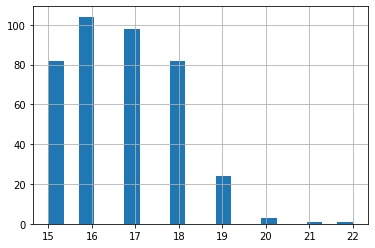

In [10]:
student_df['age'].hist(bins=20);

### Imbalanced data
You can see from the plot above that the student dataset is imbalanced. 
- Since there are very few observations with age equal to 20, 21 and 22, we can drop these observations from the dataset. 
- That can be done by removing data belonging to all greater than 20.

In [11]:
#get data with students ages less than 20
df = df[(df['age'] < 20)]

# reset index and drop the old one
df = df.reset_index(drop=True)

####Now lets plot again to see the new dataset

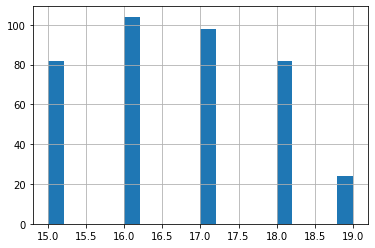

In [12]:
df['age'].hist(bins=20);

####This will chart the students romantic status.

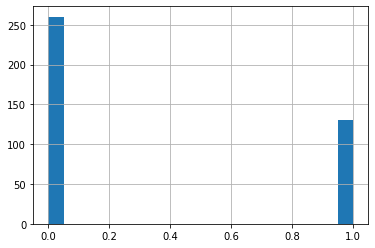

In [14]:
df['romantic1'].hist(bins=20);

### Train Test Split

Next, we will split the datasets into training, test and validation datasets.
- The data frame will be split 80:20 into `train` and `test` sets.
- The resulting `train` will then be split 80:20 into `train` and `val` sets.
- The `train_test_split` parameter `test_size` takes a float value that ranges between 0. and 1, and represents the proportion of the dataset that is allocated to the test set.  The rest of the data is allocated to the training set.

In [13]:
# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 0)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 0)

Exploring the training stats. We will pop the labels 'romantic' and 'age' from the data as these will be used as the labels


In [14]:
train_stats = train.describe()      #This does not work with data that cointains strings
train_stats.pop('romantic1')
train_stats.pop('age')
train_stats = train_stats.transpose()

In [46]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Medu,249.0,2.738956,1.110856,0.0,2.0,3.0,4.0,4.0
Fedu,249.0,2.522088,1.051360,1.0,2.0,3.0,3.0,4.0
traveltime,249.0,1.473896,0.724236,1.0,1.0,1.0,2.0,4.0
studytime,249.0,2.024096,0.851601,1.0,1.0,2.0,2.0,4.0
failures,249.0,0.305221,0.686280,0.0,0.0,0.0,0.0,3.0
famrel,249.0,3.871486,0.933014,1.0,3.0,4.0,4.0,5.0
freetime,249.0,3.172691,0.991037,1.0,3.0,3.0,4.0,5.0
goout,249.0,3.024096,1.128544,1.0,2.0,3.0,4.0,5.0
Dalc,249.0,1.465863,0.884362,1.0,1.0,1.0,2.0,5.0
Walc,249.0,2.248996,1.267717,1.0,1.0,2.0,3.0,5.0




### Getting the labels

The features and labels are currently in the same dataframe.
- We want to store the label columns `age` and `romantic` separately from the feature columns.  
- The following function, `format_output`, gets these two columns from the dataframe.
- `format_output` also formats the data into numpy arrays. 


In [15]:
def format_output(data):
    age = data.pop('age')
    age = np.array(age)
    romantic1 = data.pop('romantic1')
    romantic1 = np.array(romantic1)
    return (age, romantic1)

In [16]:
# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

In [21]:
train_Y

(array([17, 15, 15, 16, 18, 18, 16, 16, 17, 17, 17, 15, 17, 15, 16, 17, 19,
        17, 16, 18, 18, 16, 16, 17, 18, 16, 18, 15, 16, 17, 19, 15, 17, 16,
        16, 19, 18, 17, 18, 18, 18, 15, 17, 17, 19, 17, 16, 16, 16, 18, 15,
        18, 18, 15, 18, 16, 15, 15, 17, 17, 17, 18, 15, 17, 16, 16, 17, 16,
        16, 17, 17, 16, 16, 17, 17, 17, 16, 16, 18, 17, 17, 18, 18, 15, 15,
        15, 15, 19, 15, 15, 17, 18, 15, 18, 17, 16, 15, 17, 19, 18, 15, 16,
        18, 15, 15, 16, 15, 15, 17, 15, 15, 18, 19, 15, 19, 18, 16, 19, 16,
        18, 16, 19, 18, 17, 18, 18, 16, 18, 18, 17, 16, 18, 15, 17, 18, 16,
        19, 15, 16, 18, 15, 16, 18, 16, 18, 15, 17, 17, 18, 16, 18, 16, 16,
        15, 17, 18, 18, 16, 17, 18, 17, 18, 17, 18, 16, 16, 16, 16, 17, 16,
        15, 18, 15, 15, 16, 18, 16, 15, 15, 19, 15, 17, 16, 16, 15, 18, 19,
        19, 15, 19, 16, 17, 15, 15, 17, 19, 16, 16, 15, 18, 15, 18, 15, 17,
        15, 19, 16, 17, 16, 15, 16, 15, 17, 18, 16, 17, 17, 17, 16, 15, 16,
        16, 

After we get the labels, the `train`, `val` and `test` dataframes no longer contain the label columns, and contain just the feature columns.
- This is because you used `.pop` in the `format_output` function.

In [22]:
train.head()

,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,famsize1,Mjob1,school1,sex1,address1,Pstatus1,Fjob1,reason1,guardian1,schoolsup1,famsup1,paid1,activities1,nursery1,higher1,internet1
300,4,4,2,1,0,4,1,1,2,2,5,0,11,11,10,1.0,2.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
113,4,2,1,1,0,3,5,2,1,1,3,10,18,19,19,1.0,4.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
104,3,4,1,2,0,5,4,4,1,1,1,0,16,18,18,0.0,3.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
151,2,1,1,1,1,4,4,4,3,5,5,6,12,13,14,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
381,4,2,2,1,1,5,4,3,4,3,3,14,6,5,5,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


### Normalize the data

Next, we normalize the data, x, using the formula:
$$x_{norm} = \frac{x - \mu}{\sigma}$$

In [17]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [18]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

## Define the Model

Here we difine the model using the functional API. The base model will be 2 `Dense` layers of 128 neurons each, and have the `'relu'` activation.
- Check out the documentation for [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [19]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = Dense(units='128', activation='relu')(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(units='128', activation='relu')(x) 
    return x

### Define output layers of the model

Here we add output layers to the base model. 
- The model will need two outputs.

One output layer will predict the student age, which is a numeric value.
- Define a `Dense` layer with 1 neuron.
- Since this is a regression output, the activation can be left as its default value `None`.

The other output layer will predict the student romantic status, which is either in a romantic relationship `1` or not single `0` (white).
- We define a `Dense` layer with 1 neuron.
- Since there are two possible categories, you can use a sigmoid activation for binary classification.


In [20]:
def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    student_age = Dense(units='1', name='student_age')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    student_romantic = Dense(units='1', activation='sigmoid', name='student_romantic')(x)

    # define the model using the input and output layers
    model = Model(inputs=inputs, outputs= [student_age, student_romantic])

    return model

## Compiling the Model

Next, we compile the model. When setting the loss parameter of `model.compile`, we're setting the loss for each of the two outputs (student age and student romantic status).


- Student romantic status: Since you will be performing binary classification on wine type, you should use the binary crossentropy loss function for it..  
  
- Student age: since this is a regression output, use the mean squared error.
 



In [21]:
inputs = tf.keras.layers.Input(shape=(31,))#inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'student_romantic' : 'binary_crossentropy',
                      'student_age' :'mean_squared_error' 
                     },
              metrics = {'student_romantic' : 'accuracy',
                         'student_age': tf.keras.metrics.RootMeanSquaredError()
                       }
             )

In [ ]:
#This is to see what the model expect in order to deal with errors
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

This could be used if we want to convert other data typs into float32

In [21]:
# train_Y = np.asarray(train_Y).astype(np.float32)
# test_Y = np.asarray(test_Y).astype(np.float32)
# norm_train_X = np.asarray(norm_train_X).astype(np.float32)
# norm_test_X = np.asarray(norm_test_X).astype(np.float32)

In [22]:
type_test=np.array(train)
type_test.dtype

dtype('int64')

## Training the Model

Using the normalized data

In [22]:

history = model.fit(norm_train_X ,train_Y,# norm_train_X instead of train
                    epochs = 180, validation_data=(norm_test_X , test_Y)) # norm_test_X instead of test

Epoch 1/180
8/8 [==============================] - 3s 76ms/step - loss: 270.8233 - student_age_loss: 270.0948 - student_romantic_loss: 0.7285 - student_age_root_mean_squared_error: 16.4334 - student_romantic_accuracy: 0.4550 - val_loss: 261.8276 - val_student_age_loss: 261.0906 - val_student_romantic_loss: 0.7370 - val_student_age_root_mean_squared_error: 16.1583 - val_student_romantic_accuracy: 0.4872
Epoch 2/180
8/8 [==============================] - 0s 10ms/step - loss: 258.0868 - student_age_loss: 257.3643 - student_romantic_loss: 0.7225 - student_age_root_mean_squared_error: 16.0425 - student_romantic_accuracy: 0.4927 - val_loss: 254.0011 - val_student_age_loss: 253.2634 - val_student_romantic_loss: 0.7377 - val_student_age_root_mean_squared_error: 15.9143 - val_student_romantic_accuracy: 0.4615
Epoch 3/180
8/8 [==============================] - 0s 9ms/step - loss: 251.7231 - student_age_loss: 250.9939 - student_romantic_loss: 0.7292 - student_age_root_mean_squared_error: 15.8426 

In [23]:
# Gather the training metrics
loss, student_age_loss, student_romantic_loss, student_age_rmse, student_romantic_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'student_age_loss: {student_age_loss}')
print(f'student_romantic_loss: {student_romantic_loss}')
print(f'student_age_rmse: {student_age_rmse}')
print(f'student_romantic_accuracy: {student_romantic_accuracy}')

2/2 [==============================] - 0s 4ms/step - loss: 4.8782 - student_age_loss: 4.2166 - student_romantic_loss: 0.6616 - student_age_root_mean_squared_error: 2.0534 - student_romantic_accuracy: 0.6190

loss: 4.878199577331543
student_age_loss: 4.216577053070068
student_romantic_loss: 0.6616226434707642
student_age_rmse: 2.0534305572509766
student_romantic_accuracy: 0.6190476417541504


## Analyze the Model Performance
The model has two outputs. The output at index 0 is student age and index 1 is student romantic status


In [27]:
predictions = model.predict(norm_test_X)
age_pred = predictions[0]
romantic_pred = predictions[1]

In [29]:
print(age_pred[0])
print(romantic_pred[0])

[18.337074]
[0.30230904]


In [30]:
print(type_pred[9])

[0.38243055]


### Plot Utilities

We define a few utilities to visualize the model performance.

In [31]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [32]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [33]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

### Plots for Metrics

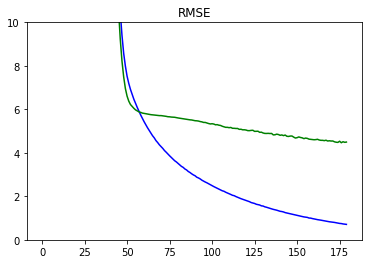

In [40]:
plot_metrics('student_age_loss', 'RMSE', ylim=10)

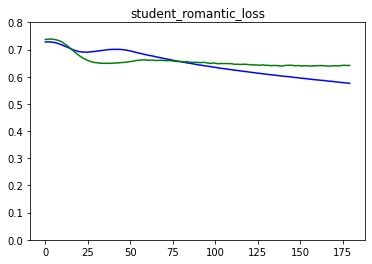

In [43]:
plot_metrics('student_romantic_loss', 'student_romantic_loss', ylim=0.8)

### Plots for Confusion Matrix

Plot the confusion matrices for student romantic status. We can see that the model performs well for prediction of romantic from the confusion matrix and the loss metrics.

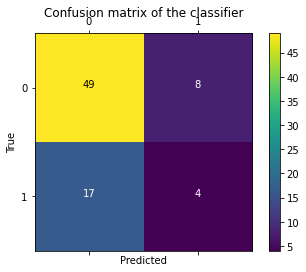

In [44]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

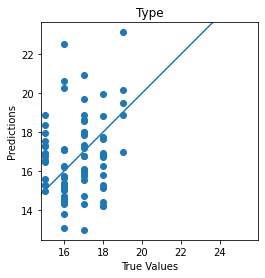

In [45]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')